In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


!unzip '/content/gdrive/MyDrive/2.zip'



import os
a = '/content/1/test/aeroplane'
path, dirs, files = next(os.walk(a))
file_count = len(files)
print(file_count)


import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])


train_data_dir = "/content/1/train"

val_data_dir = "/content/1/val"
test_data_dir = "/content/1/test"
# take the dataset from the location nad transform it 
trainset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
#divide the data into batches with batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)
print(len(trainset))

valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valnset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)




import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=5)
         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()

########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion,net):
    running_loss = 0.0
    correct=0
    total=0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    print('Accuracy of the network on the train images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

    
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/bestmodelconv5.pth')


Streaming output truncated to the last 5000 lines.
  inflating: 1/train/bird/pipit_s_000221.png  
 extracting: 1/train/bird/passerine_s_001226.png  
 extracting: 1/train/bird/emu_s_001158.png  
 extracting: 1/train/bird/accentor_s_000039.png  
 extracting: 1/train/bird/pipit_s_000029.png  
 extracting: 1/train/bird/ostrich_s_002262.png  
 extracting: 1/train/bird/struthio_camelus_s_000156.png  
  inflating: 1/train/bird/flightless_bird_s_000353.png  
 extracting: 1/train/bird/pipit_s_000443.png  
 extracting: 1/train/bird/ostrich_s_000506.png  
  inflating: 1/train/bird/sparrow_s_000490.png  
  inflating: 1/train/bird/ostrich_s_002057.png  
  inflating: 1/train/bird/meadow_pipit_s_000610.png  
 extracting: 1/train/bird/cassowary_s_001833.png  
 extracting: 1/train/bird/flying_bird_s_000775.png  
  inflating: 1/train/bird/dunnock_s_001078.png  
  inflating: 1/train/bird/emu_s_000258.png  
 extracting: 1/train/bird/dunnock_s_000507.png  
 extracting: 1/train/bird/passerine_s_000671.png  

100%|██████████| 6250/6250 [00:55<00:00, 111.61it/s]


epoch 1 training loss: 1.466
Accuracy of the network on the train images: 28.704000 %


100%|██████████| 625/625 [00:03<00:00, 192.97it/s]


Accuracy of the network on the test images: 40.560000 %
epoch  2


100%|██████████| 6250/6250 [00:46<00:00, 133.14it/s]


epoch 2 training loss: 1.159
Accuracy of the network on the train images: 46.240000 %


100%|██████████| 625/625 [00:04<00:00, 154.76it/s]


Accuracy of the network on the test images: 49.440000 %
epoch  3


100%|██████████| 6250/6250 [00:46<00:00, 133.94it/s]


epoch 3 training loss: 1.015
Accuracy of the network on the train images: 55.612000 %


100%|██████████| 625/625 [00:03<00:00, 201.53it/s]


Accuracy of the network on the test images: 56.120000 %
epoch  4


100%|██████████| 6250/6250 [00:48<00:00, 128.72it/s]


epoch 4 training loss: 0.881
Accuracy of the network on the train images: 63.052000 %


100%|██████████| 625/625 [00:03<00:00, 197.44it/s]


Accuracy of the network on the test images: 66.240000 %
epoch  5


100%|██████████| 6250/6250 [00:46<00:00, 133.96it/s]


epoch 5 training loss: 0.750
Accuracy of the network on the train images: 69.424000 %


100%|██████████| 625/625 [00:03<00:00, 197.05it/s]


Accuracy of the network on the test images: 70.360000 %
epoch  6


100%|██████████| 6250/6250 [00:48<00:00, 130.04it/s]


epoch 6 training loss: 0.641
Accuracy of the network on the train images: 74.512000 %


100%|██████████| 625/625 [00:03<00:00, 195.13it/s]


Accuracy of the network on the test images: 74.760000 %
epoch  7


100%|██████████| 6250/6250 [00:46<00:00, 133.27it/s]


epoch 7 training loss: 0.547
Accuracy of the network on the train images: 78.552000 %


100%|██████████| 625/625 [00:03<00:00, 196.34it/s]


Accuracy of the network on the test images: 76.640000 %
epoch  8


100%|██████████| 6250/6250 [00:48<00:00, 129.55it/s]


epoch 8 training loss: 0.464
Accuracy of the network on the train images: 82.044000 %


100%|██████████| 625/625 [00:03<00:00, 196.21it/s]


Accuracy of the network on the test images: 78.680000 %
epoch  9


100%|██████████| 6250/6250 [00:46<00:00, 133.21it/s]


epoch 9 training loss: 0.384
Accuracy of the network on the train images: 85.216000 %


100%|██████████| 625/625 [00:03<00:00, 194.91it/s]


Accuracy of the network on the test images: 80.680000 %
epoch  10


100%|██████████| 6250/6250 [00:48<00:00, 127.83it/s]


epoch 10 training loss: 0.315
Accuracy of the network on the train images: 87.788000 %


100%|██████████| 625/625 [00:03<00:00, 197.38it/s]


Accuracy of the network on the test images: 80.440000 %
epoch  11


100%|██████████| 6250/6250 [00:46<00:00, 133.12it/s]


epoch 11 training loss: 0.251
Accuracy of the network on the train images: 90.692000 %


100%|██████████| 625/625 [00:03<00:00, 198.00it/s]


Accuracy of the network on the test images: 81.080000 %
epoch  12


100%|██████████| 6250/6250 [00:47<00:00, 130.47it/s]


epoch 12 training loss: 0.202
Accuracy of the network on the train images: 92.436000 %


100%|██████████| 625/625 [00:03<00:00, 197.57it/s]


Accuracy of the network on the test images: 81.240000 %
epoch  13


100%|██████████| 6250/6250 [00:46<00:00, 134.36it/s]


epoch 13 training loss: 0.158
Accuracy of the network on the train images: 94.172000 %


100%|██████████| 625/625 [00:03<00:00, 197.30it/s]


Accuracy of the network on the test images: 81.120000 %
epoch  14


100%|██████████| 6250/6250 [00:47<00:00, 130.31it/s]


epoch 14 training loss: 0.126
Accuracy of the network on the train images: 95.452000 %


100%|██████████| 625/625 [00:03<00:00, 195.79it/s]


Accuracy of the network on the test images: 83.000000 %
epoch  15


100%|██████████| 6250/6250 [00:46<00:00, 133.89it/s]


epoch 15 training loss: 0.108
Accuracy of the network on the train images: 96.052000 %


100%|██████████| 625/625 [00:03<00:00, 198.81it/s]


Accuracy of the network on the test images: 81.520000 %
epoch  16


100%|██████████| 6250/6250 [00:48<00:00, 128.57it/s]


epoch 16 training loss: 0.087
Accuracy of the network on the train images: 96.860000 %


100%|██████████| 625/625 [00:03<00:00, 201.16it/s]


Accuracy of the network on the test images: 81.720000 %
epoch  17


100%|██████████| 6250/6250 [00:47<00:00, 131.23it/s]


epoch 17 training loss: 0.077
Accuracy of the network on the train images: 97.324000 %


100%|██████████| 625/625 [00:03<00:00, 196.71it/s]


Accuracy of the network on the test images: 81.720000 %
epoch  18


100%|██████████| 6250/6250 [00:48<00:00, 130.03it/s]


epoch 18 training loss: 0.070
Accuracy of the network on the train images: 97.544000 %


100%|██████████| 625/625 [00:03<00:00, 197.95it/s]


Accuracy of the network on the test images: 81.680000 %
epoch  19


100%|██████████| 6250/6250 [00:46<00:00, 133.42it/s]


epoch 19 training loss: 0.056
Accuracy of the network on the train images: 98.092000 %


100%|██████████| 625/625 [00:03<00:00, 197.90it/s]


Accuracy of the network on the test images: 82.360000 %
epoch  20


100%|██████████| 6250/6250 [00:48<00:00, 130.03it/s]


epoch 20 training loss: 0.039
Accuracy of the network on the train images: 98.704000 %


100%|██████████| 625/625 [00:03<00:00, 196.61it/s]


Accuracy of the network on the test images: 81.360000 %
epoch  21


100%|██████████| 6250/6250 [00:46<00:00, 133.61it/s]


epoch 21 training loss: 0.041
Accuracy of the network on the train images: 98.644000 %


100%|██████████| 625/625 [00:03<00:00, 198.28it/s]


Accuracy of the network on the test images: 79.400000 %
epoch  22


100%|██████████| 6250/6250 [00:48<00:00, 129.01it/s]


epoch 22 training loss: 0.042
Accuracy of the network on the train images: 98.572000 %


100%|██████████| 625/625 [00:03<00:00, 198.23it/s]


Accuracy of the network on the test images: 81.400000 %
epoch  23


100%|██████████| 6250/6250 [00:47<00:00, 132.27it/s]


epoch 23 training loss: 0.046
Accuracy of the network on the train images: 98.428000 %


100%|██████████| 625/625 [00:03<00:00, 167.53it/s]


Accuracy of the network on the test images: 80.960000 %
epoch  24


100%|██████████| 6250/6250 [00:46<00:00, 133.70it/s]


epoch 24 training loss: 0.036
Accuracy of the network on the train images: 98.812000 %


100%|██████████| 625/625 [00:03<00:00, 199.00it/s]


Accuracy of the network on the test images: 82.640000 %
epoch  25


100%|██████████| 6250/6250 [00:48<00:00, 129.97it/s]


epoch 25 training loss: 0.035
Accuracy of the network on the train images: 98.840000 %


100%|██████████| 625/625 [00:03<00:00, 198.08it/s]


Accuracy of the network on the test images: 81.480000 %
epoch  26


100%|██████████| 6250/6250 [00:46<00:00, 134.28it/s]


epoch 26 training loss: 0.029
Accuracy of the network on the train images: 99.020000 %


100%|██████████| 625/625 [00:03<00:00, 199.17it/s]


Accuracy of the network on the test images: 82.160000 %
epoch  27


100%|██████████| 6250/6250 [00:47<00:00, 130.95it/s]


epoch 27 training loss: 0.033
Accuracy of the network on the train images: 98.916000 %


100%|██████████| 625/625 [00:03<00:00, 196.60it/s]


Accuracy of the network on the test images: 80.920000 %
epoch  28


100%|██████████| 6250/6250 [00:46<00:00, 133.33it/s]


epoch 28 training loss: 0.027
Accuracy of the network on the train images: 99.176000 %


100%|██████████| 625/625 [00:03<00:00, 193.52it/s]


Accuracy of the network on the test images: 82.400000 %
epoch  29


100%|██████████| 6250/6250 [00:47<00:00, 130.88it/s]


epoch 29 training loss: 0.034
Accuracy of the network on the train images: 98.888000 %


100%|██████████| 625/625 [00:03<00:00, 201.69it/s]


Accuracy of the network on the test images: 83.160000 %
epoch  30


100%|██████████| 6250/6250 [00:46<00:00, 134.44it/s]


epoch 30 training loss: 0.032
Accuracy of the network on the train images: 98.952000 %


100%|██████████| 625/625 [00:03<00:00, 202.14it/s]


Accuracy of the network on the test images: 80.720000 %
epoch  31


100%|██████████| 6250/6250 [00:47<00:00, 131.09it/s]


epoch 31 training loss: 0.029
Accuracy of the network on the train images: 99.008000 %


100%|██████████| 625/625 [00:03<00:00, 200.34it/s]


Accuracy of the network on the test images: 82.240000 %
epoch  32


100%|██████████| 6250/6250 [00:46<00:00, 134.09it/s]


epoch 32 training loss: 0.024
Accuracy of the network on the train images: 99.316000 %


100%|██████████| 625/625 [00:03<00:00, 202.32it/s]


Accuracy of the network on the test images: 83.480000 %
epoch  33


100%|██████████| 6250/6250 [00:47<00:00, 130.68it/s]


epoch 33 training loss: 0.007
Accuracy of the network on the train images: 99.828000 %


100%|██████████| 625/625 [00:03<00:00, 183.54it/s]


Accuracy of the network on the test images: 84.240000 %
epoch  34


100%|██████████| 6250/6250 [00:46<00:00, 134.07it/s]


epoch 34 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 196.27it/s]


Accuracy of the network on the test images: 84.520000 %
epoch  35


100%|██████████| 6250/6250 [00:48<00:00, 129.67it/s]


epoch 35 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 201.24it/s]


Accuracy of the network on the test images: 84.720000 %
epoch  36


100%|██████████| 6250/6250 [00:46<00:00, 133.90it/s]


epoch 36 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 200.96it/s]


Accuracy of the network on the test images: 84.800000 %
epoch  37


100%|██████████| 6250/6250 [00:50<00:00, 123.70it/s]


epoch 37 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:04<00:00, 135.65it/s]


Accuracy of the network on the test images: 84.440000 %
epoch  38


100%|██████████| 6250/6250 [00:48<00:00, 129.75it/s]


epoch 38 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 187.93it/s]


Accuracy of the network on the test images: 84.720000 %
epoch  39


100%|██████████| 6250/6250 [00:46<00:00, 133.58it/s]


epoch 39 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 197.07it/s]


Accuracy of the network on the test images: 84.360000 %
epoch  40


100%|██████████| 6250/6250 [00:47<00:00, 131.20it/s]


epoch 40 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 194.81it/s]


Accuracy of the network on the test images: 84.440000 %
epoch  41


100%|██████████| 6250/6250 [00:46<00:00, 133.16it/s]


epoch 41 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 203.57it/s]


Accuracy of the network on the test images: 84.000000 %
epoch  42


100%|██████████| 6250/6250 [00:47<00:00, 131.25it/s]


epoch 42 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 201.55it/s]


Accuracy of the network on the test images: 84.160000 %
epoch  43


100%|██████████| 6250/6250 [00:46<00:00, 134.18it/s]


epoch 43 training loss: 0.001
Accuracy of the network on the train images: 100.000000 %


100%|██████████| 625/625 [00:03<00:00, 197.39it/s]


Accuracy of the network on the test images: 84.200000 %
epoch  44


100%|██████████| 6250/6250 [00:47<00:00, 130.70it/s]


epoch 44 training loss: 0.003
Accuracy of the network on the train images: 99.960000 %


100%|██████████| 625/625 [00:03<00:00, 201.75it/s]


Accuracy of the network on the test images: 80.840000 %
epoch  45


100%|██████████| 6250/6250 [00:46<00:00, 134.90it/s]


epoch 45 training loss: 0.106
Accuracy of the network on the train images: 96.552000 %


100%|██████████| 625/625 [00:03<00:00, 199.96it/s]


Accuracy of the network on the test images: 80.280000 %
epoch  46


100%|██████████| 6250/6250 [00:47<00:00, 131.86it/s]


epoch 46 training loss: 0.094
Accuracy of the network on the train images: 96.812000 %


100%|██████████| 625/625 [00:03<00:00, 199.05it/s]


Accuracy of the network on the test images: 78.520000 %
epoch  47


100%|██████████| 6250/6250 [00:46<00:00, 133.68it/s]


epoch 47 training loss: 0.087
Accuracy of the network on the train images: 97.044000 %


100%|██████████| 625/625 [00:03<00:00, 203.67it/s]


Accuracy of the network on the test images: 82.880000 %
epoch  48


100%|██████████| 6250/6250 [00:47<00:00, 130.89it/s]


epoch 48 training loss: 0.069
Accuracy of the network on the train images: 97.640000 %


100%|██████████| 625/625 [00:03<00:00, 201.56it/s]


Accuracy of the network on the test images: 80.680000 %
epoch  49


100%|██████████| 6250/6250 [00:46<00:00, 134.75it/s]


epoch 49 training loss: 0.057
Accuracy of the network on the train images: 98.100000 %


100%|██████████| 625/625 [00:03<00:00, 198.88it/s]


Accuracy of the network on the test images: 82.560000 %
epoch  50


100%|██████████| 6250/6250 [00:47<00:00, 132.11it/s]


epoch 50 training loss: 0.051
Accuracy of the network on the train images: 98.312000 %


100%|██████████| 625/625 [00:03<00:00, 201.33it/s]


Accuracy of the network on the test images: 81.960000 %
performing test


100%|██████████| 625/625 [00:03<00:00, 199.77it/s]


Accuracy of the network on the test images: 80.240000 %


100%|██████████| 625/625 [00:03<00:00, 192.73it/s]

Accuracy of  aeroplane : 88.200000 %
Accuracy of       bird : 72.600000 %
Accuracy of        cat : 78.600000 %
Accuracy of        dog : 71.600000 %
Accuracy of       ship : 90.200000 %
Finished Training


In [ ]:
print(len(train_accuracies))
print(len(val_accuracies))
with open(r'trainconv5.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)

50
50


In [ ]:
with open(r'valconv5.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)

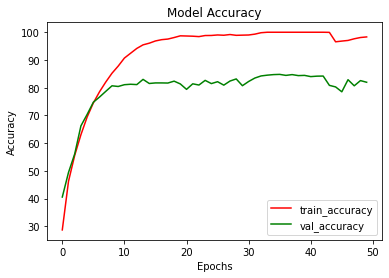

In [ ]:
epochs= np.arange(0, 50, 1)
  
# Assign variables to the y axis part of the curve
y = train_accuracies
z = val_accuracies
  
# Plotting both the curves simultaneously
plt.plot(epochs, y, color='r', label='train_accuracy')
plt.plot(epochs, z, color='g', label='val_accuracy')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()